# Simulating True Market Variability

The idea here is to compare Ecoinvent market simulation runs to the individual supplier production processes to show that, given basic uncertainty about the specific process used to create a product, the market far underestimates uncertainty in the impact of the production.  

The default uncertainty configuration computes variation of the expected value of the market-wide average, so it does not express the dynamic range in the supplier inputs. Also, the mix parameters themselves are not adjusted for uncertainty, having to sum to 1, so not even the market weights are varied.

So you wind up with a static average of stochastic variables that causes the confidence interval to collapse.  This (fails catastrophically if process variability is meant to contribute to uncertainty) is not necessarily consistent with the objectives of a stochastic simulation. 

If there is basic uncertainty about the specific supplier or technology from which a technosphere input is drawn, the prior assumption should be that the supplier is not known, but will be drawn from a weighted set.  This is naturally represented as a discrete probability distribution. 

the Ecoinvent approach is to assume that the input is a market-weighted average of all known suppliers.  This may sometimes be appropriate, but generally only if the study scope is the global market. 


In [1]:
import sys
import re
import time
from antelope_catalog import LcCatalog
STUDY_PATH = '/data/GitHub/2019/variability_jlca/'

sys.path.append(STUDY_PATH)

cat = LcCatalog(STUDY_PATH + 'catalog', quell_biogenic_co2=True)

Loading JSON data from /data/GitHub/lca-tools/lcatools/qdb/data/flowable_synlist.json:
Loading JSON data from /data/GitHub/lca-tools/lcatools/qdb/data/quantity_synlist.json:
local.qdb: /data/GitHub/2019/variability_jlca/catalog/reference-quantities.json
Loading JSON data from /data/GitHub/2019/variability_jlca/catalog/reference-quantities.json:
local.qdb: /data/GitHub/lca-tools/lcatools/qdb/data/elcd_reference_quantities.json
25 new quantity entities added (25 total)
6 new flow entities added (6 total)


In [2]:
cat.show_interfaces()

local.ecoinvent.3.4.apos [basic, inventory]
local.ecoinvent.3.4.apos.index.20190204 [background, basic, index]
local.ecoinvent.3.4.conseq [basic, inventory]
local.ecoinvent.3.4.cutoff [basic, inventory]
local.ecoinvent.3.4.cutoff.index.20190204 [background, basic, index]
local.lcia.ecoinvent.3.1 [basic, index, quantity]
local.qdb [basic, index, quantity]


In [3]:
recipe_methods = [('ReCiPe Midpoint (H)', 'climate change', 'GWP100'),
                  ('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'),
                  ('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'),
                  ('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP')
                 ]

# cached right?
qs = [cat.query('local.lcia.ecoinvent.3.1').get(', '.join(rm)) for rm in recipe_methods]


local.lcia.ecoinvent.3.1: /data/LCI/Ecoinvent/LCIA/LCIA implementation v3.1 2014_08_13.xlsx
Loading JSON data from /data/GitHub/2019/variability_jlca/catalog/cache/cfa3982d248fbdf0224e3ebad316063c182bbbbd.json.gz:
local.lcia.ecoinvent.3.1: /data/GitHub/2019/variability_jlca/catalog/cache/cfa3982d248fbdf0224e3ebad316063c182bbbbd.json.gz
703 new quantity entities added (703 total)
3255 new flow entities added (3255 total)


In [4]:
from lca_variability import initialize_activity, initialize_market_model

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
from lca_variability import MarketIterator

In [7]:
qa = cat.query('local.ecoinvent.3.4.apos')
mi_apos = MarketIterator(qa, *qs, lu_factorization=False)

In [8]:
qc = cat.query('local.ecoinvent.3.4.cutoff')
mi_cutoff = MarketIterator(qc, *qs, lu_factorization=False)

In [9]:
from math import ceil
import time
import numpy as np

In [10]:
from lca_variability.mca_charts import TraceLine, mc_mkt_combo

## Generate Example Figures for Part 2

In [11]:
# application functions

db_map = {'local.ecoinvent.3.4.apos': ('ei3.4 apos', mi_apos),
          'local.ecoinvent.3.4.cutoff': ('ei3.4 cutoff', mi_cutoff)}

def generate_runs_by_id(origin, mkt_ref, steps=1200):
    _ts = time.time()
    _dbs = db_map[origin]
    print('=== time %.3f ===' % (time.time() - _ts))
    _mkt_study = _dbs[1].get_result(mkt_ref)
    print('=== time %.3f ===' % (time.time() - _ts))
    _mca = initialize_activity(_dbs[0], mkt_ref, *recipe_methods, steps=steps)
    print('=== time %.3f ===' % (time.time() - _ts))
    return _mkt_study, _mca


def _market_name(market):
    name = re.sub('Europe without Switzerland', 'EU excl. CH', market._name)
    return name


def _plot_mkt_run(_ax, _study, _mca, index=0, style='stem', annot=None, traces=None, **kwargs):
    if annot is None:
        annot = {'title': _market_name(_study.market),
                 'method': '%s: %s [%s]' % recipe_methods[index],
                 'ei': db_map[_study.market.origin][0]
                }
    tr=[TraceLine(_study.market_scores[index], label='Market average')]
    if traces is not None:
        tr.extend(traces)
        
    # ts traces
    if _study.market.external_ref == '4d024c87-fcab-4980-9347-c3bee224671f':
        if recipe_methods[index] in ts_data:
            data = ts_data[recipe_methods[index]]
            styles = ts_data['linestyles']
            for i, p in enumerate(ts_data['processes']):
                tr.append(TraceLine(data[i], label=p, **styles[i]))
    
    mc_mkt_combo(_ax, _study.scores(qs[index]), _study.exchange_values, _mca.scores(recipe_methods[index]),
                annot=annot, style=style, traces=tr, **kwargs)
    
def plot_mkt_run(_study, _mca, index=0, **kwargs):
    if isinstance(index, int):
        ax = plt.axes()
        _plot_mkt_run(ax, _study, _mca, index=index, **kwargs)
        return ax
        
    else:
        _axs = []
        annot = {'title': _market_name(_study.market),
                'ei': db_map[_study.market.origin][0].upper()}
        l = len(index)
        if l == 4:
            fig = plt.figure(figsize=(12, 8))
        else:
            fig = plt.figure(figsize=(8, 4 * l))
        for i, v in enumerate(index):
            annot['method'] = recipe_methods[v]
            if l == 4:
                _axs.append(fig.add_subplot(2, 2, i+1))
            else:
                _axs.append(fig.add_subplot(l, 1, i+1))
            _plot_mkt_run(_axs[-1], _study, _mca, index=v, annot=annot, **kwargs)
            
            annot['title'] = ''
        _axs[0].legend()
        return _axs
        
def generate_mkt_runs_by_id(origin, mkt_ref, steps=1200, do_activity=True, do_market=False):
    _ts = time.time()
    _dbs = db_map[origin]
    print('=== time %.3f ===' % (time.time() - _ts))
    _mkt_study = _dbs[1].get_result(mkt_ref)
    print('=== time %.3f ===' % (time.time() - _ts))
    if do_activity:
        _mca = initialize_activity(_dbs[0], mkt_ref, *recipe_methods, steps=steps)
        print('=== time %.3f ===' % (time.time() - _ts))
    else:
         _mca = None
    if do_market:
        _mca_mkt = initialize_market_model('ei3.4 cutoff', _mca.activity.get('activity'), *recipe_methods, steps=500)
        print('=== time %.3f ===' % (time.time() - _ts))
    else:
        _mca_mkt = None
    return _mkt_study, _mca, _mca_mkt


In [12]:
## cutoffs
origin = 'local.ecoinvent.3.4.cutoff'

### Large markets n>10
ext_id, plot_name = '45590532-cfd4-46a9-abb5-209e0d998f83', 'm4h-d-i-nng_EwS_ei34_cutoff-5k'  # district heat not from natural gas, Europe ex CH ## CONTENDER
# ext_id = '64fb9db2-cb2e-4078-b6cb-1b5f38e02f45'  # market for copper
# ext_id = '7533e0cf-bdcd-4ac0-8690-208f08f0428a'  # market for N fertilizer

### spread-out markets
# ext_id = '0deab922-a352-40d3-b114-3b5c8dfcb83d'  # diethyl ether
# ext_id, plot_name = '2846e11e-2102-48a5-baa3-7782b43d914d', 'v-o-m-e_34_cutoff'  # vegetable oil methyl ester ## WINNER
#ext_id = '3eab55e6-a0fc-48cd-b5c0-a1c090646191'  # HCN


_s, _a, _ma = generate_mkt_runs_by_id(origin, ext_id, steps=500, do_activity=True, do_market=True)
# _a.steps = 500

=== time 0.000 ===
local.ecoinvent.3.4.cutoff: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_cutoff_ecoSpold02
local.ecoinvent.3.4.cutoff.index.20190204: /data/GitHub/2019/variability_jlca/catalog/archives/local.ecoinvent.3.4.cutoff.index.20190204_background.mat
Loading JSON data from /data/GitHub/2019/variability_jlca/catalog/archives/local.ecoinvent.3.4.cutoff.index.20190204_background.mat.index.json.gz:
completed 58 iterations
Loading JSON data from /data/GitHub/2019/variability_jlca/catalog/index/ffc0f70037f9e921067e85ac7e2d4ff0ba1bc3b5.json.gz:
local.ecoinvent.3.4.cutoff.index.20190204: /data/GitHub/2019/variability_jlca/catalog/index/ffc0f70037f9e921067e85ac7e2d4ff0ba1bc3b5.json.gz
local.ecoinvent.3.4.cutoff: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_cutoff_ecoSpold02
13459 new process entities added (13459 total)
19 new quantity entities added (19 total)
4881 new flow entities added (4881 total)
Multiple CFs found: [25.0, 22.25]
Flow: [local.ecoinvent.3.4.cutoff] Methane, non-fossil [kg] [[

/data/virtualenvs/lca-tools/lib/python3.7/site-packages/scikits/umfpack/umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.24e+12)
  warnings.warn(msg, UmfpackWarning)


Up to date with 5000 samples, 4 methods
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): Trimmed 76 outliers
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 6 outliers


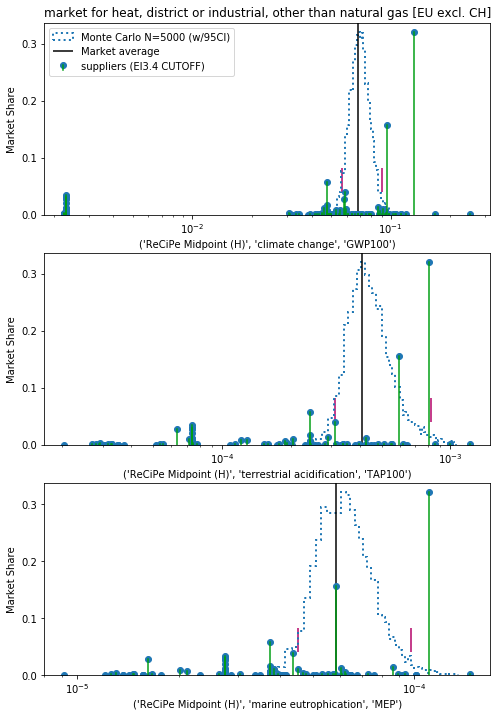

In [13]:
# Market average simulation
_a.steps = 1250
axs = plot_mkt_run(_s, _a, index=(0, 1, 3), show_ci=True)
plt.savefig('%s-average-log.eps' % plot_name, format='eps', bbox_inches='tight', transparent=True)

Up to date with 1250 samples, 4 methods
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): Trimmed 2 outliers
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 2 outliers


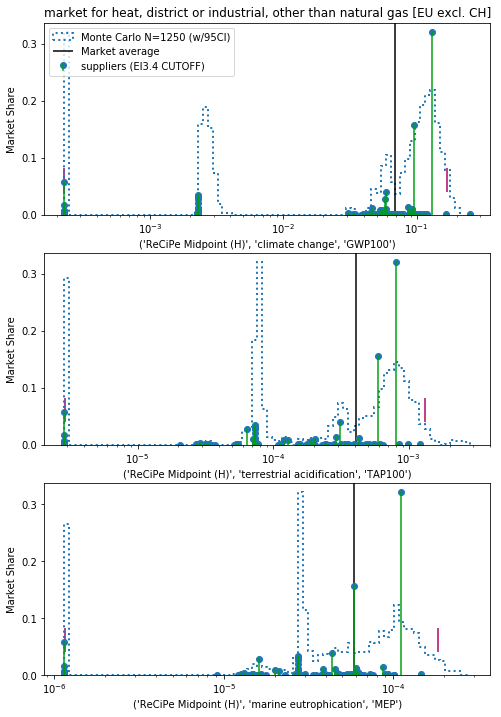

In [14]:
# Market-weighted simulation
_ma.steps = 1250
axs = plot_mkt_run(_s, _ma, index=(0, 1, 3), show_ci=True, log_correct=True, bins=80)
plt.savefig('%s-mktweight-log.eps' % plot_name, format='eps', bbox_inches='tight', transparent=True)

=== time 0.000 ===
completed 68 iterations
completed 67 iterations
completed 69 iterations
completed 66 iterations
completed 65 iterations
completed 63 iterations
completed 63 iterations
completed 63 iterations
completed 69 iterations
completed 67 iterations
completed 63 iterations
=== time 2.630 ===
Loading JSON data from /data/GitHub/2019/variability_jlca/jupyter/BW2_MCA_2846e11e-2102-48a5-baa3-7782b43d914d.json.gz:
Up to date with 1250 samples, 4 methods
=== time 2.989 ===
Loading JSON data from /data/GitHub/2019/variability_jlca/jupyter/BW2_MktWt_2846e11e-2102-48a5-baa3-7782b43d914d.json.gz:


/data/virtualenvs/lca-tools/lib/python3.7/site-packages/scikits/umfpack/umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 8.64e+12)
  warnings.warn(msg, UmfpackWarning)


Up to date with 5000 samples, 4 methods
=== time 5.272 ===
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): Trimmed 1 outliers


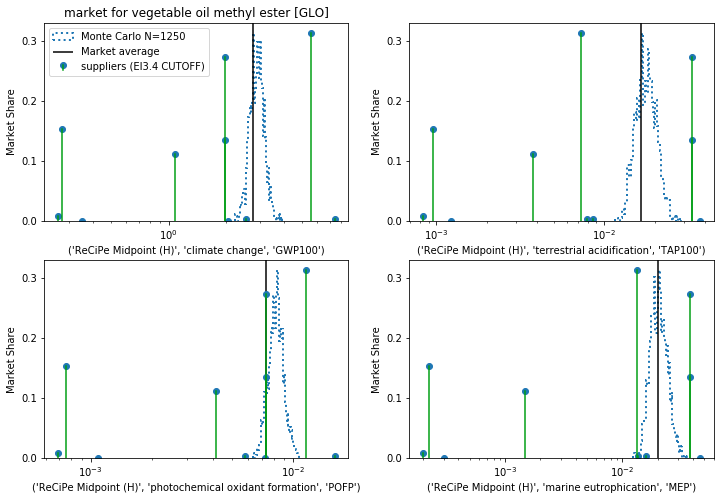

In [15]:
# another contender...
_n = '2846e11e-2102-48a5-baa3-7782b43d914d'
_s_n, _a_n, _ma_n = generate_mkt_runs_by_id(origin, _n, steps=500, do_activity=True, do_market=True)
plot_mkt_run(_s_n, _a_n, index=(0, 1, 2, 3))

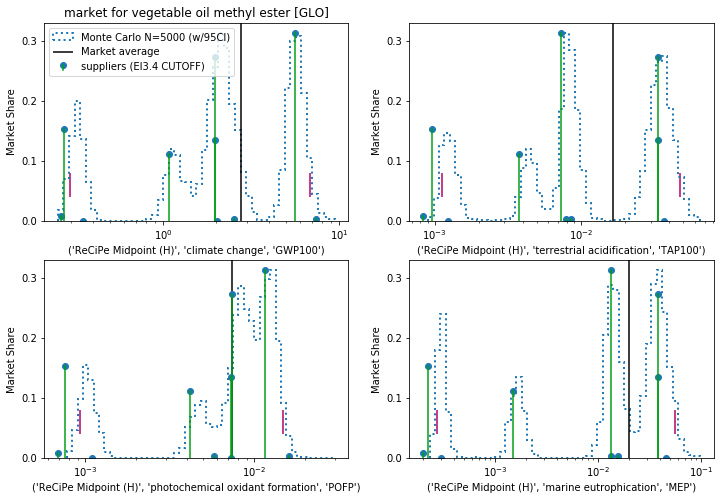

In [16]:
plot_mkt_run(_s_n, _ma_n, index=(0, 1, 2, 3), log_correct=True, show_ci=True)

# Glycerine Example
This one was ultimately is subideal vs vegetable oil methyl ester- but I had ts data so I used it in the editorial

In [17]:
M_GLY = '4d024c87-fcab-4980-9347-c3bee224671f'

# from spreadsheet from Liila Woods 2019-01-10
ts_data = {
    'processes': ['DE: Glycerine (from Epichlor.) ts',
                  'DE: Glycerine from RME ($ alloc) ts'],
    'linestyles': [
        {
            'linestyle': ':',
            'color': [1, 0, 0]
        },
        {
            'linestyle': '-.',
            'color': [0, 0, 1]
        }
    ],
    recipe_methods[0]: [8.23562061020724, 0.514477097381447],
    recipe_methods[1]: [0.007426994525449, 0.007520819864429],
    recipe_methods[3]: [0.000184808227556, 0.001475900547191]
}

In [18]:
a_gly = mi_apos.get_result(M_GLY)

local.ecoinvent.3.4.apos: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_apos_ecoSpold02
local.ecoinvent.3.4.apos.index.20190204: /data/GitHub/2019/variability_jlca/catalog/archives/local.ecoinvent.3.4.apos.index.20190204_background.mat
Loading JSON data from /data/GitHub/2019/variability_jlca/catalog/archives/local.ecoinvent.3.4.apos.index.20190204_background.mat.index.json.gz:
completed 65 iterations
Loading JSON data from /data/GitHub/2019/variability_jlca/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz:
local.ecoinvent.3.4.apos.index.20190204: /data/GitHub/2019/variability_jlca/catalog/index/a57075ecd68e35920696904ec830bc522fc6b2b2.json.gz
local.ecoinvent.3.4.apos: /data/LCI/Ecoinvent/3.4/ecoinvent 3.4_apos_ecoSpold02
13290 new process entities added (13290 total)
19 new quantity entities added (19 total)
4851 new flow entities added (4851 total)
Multiple CFs found: [25.0, 22.25]
Flow: [local.ecoinvent.3.4.apos] Methane, non-fossil [kg] [[kg]]
Quantity: ReCiPe Midpoint (H), c

In [19]:
# a = Bw2McaContainer.from_file(os.path.join(DATA_PATH, 'BW2_MCA_%s_.json.gz' % M_GLY)
a = initialize_activity('ei3.4 apos', M_GLY, *recipe_methods)

Loading JSON data from /data/GitHub/2019/variability_jlca/jupyter/BW2_MCA_4d024c87-fcab-4980-9347-c3bee224671f.json.gz:
Up to date with 5000 samples, 4 methods


('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): Trimmed 1 outliers


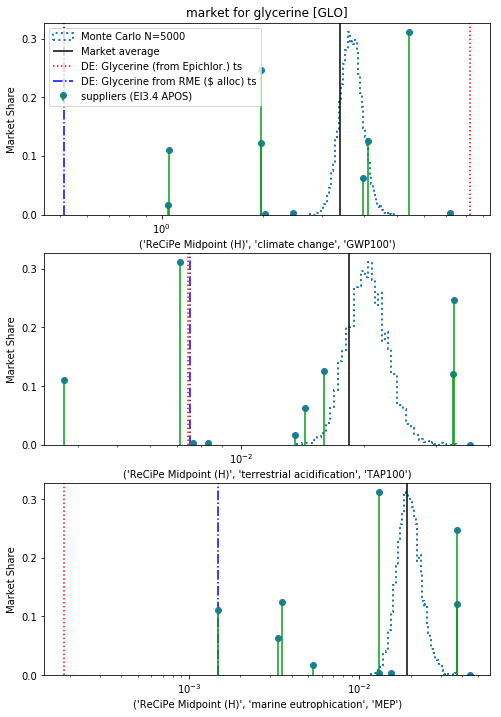

In [20]:
plot_mkt_run(a_gly, a, index=(0, 1, 3))

In [21]:
a.filename

'BW2_MCA_4d024c87-fcab-4980-9347-c3bee224671f.json.gz'

In [22]:
a_gly.market.link

'local.ecoinvent.3.4.apos/4d024c87-fcab-4980-9347-c3bee224671f'

In [23]:
f = initialize_market_model('ei3.4 apos', M_GLY, *recipe_methods)

Loading JSON data from /data/GitHub/2019/variability_jlca/jupyter/BW2_MktWt_4d024c87-fcab-4980-9347-c3bee224671f.json.gz:
Up to date with 5000 samples, 4 methods


/data/virtualenvs/lca-tools/lib/python3.7/site-packages/scikits/umfpack/umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.71e+14)
  warnings.warn(msg, UmfpackWarning)


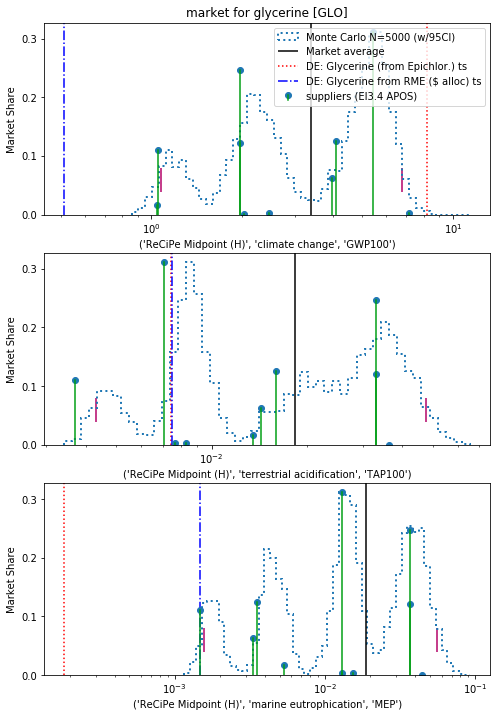

In [24]:
#f.steps = 5000
plot_mkt_run(a_gly, f, index=(0, 1, 3), log_correct=True, show_ci=True)

## Validate off-center Distribution
It is observed that the BW2 monte carlo simulation for M_GLY is not centered on the market average for GWP, which is surprising.  So we want to make sure we didn't make any mistakes by checking two things:
 1. Confirming that the BW2 point-source solution equals the Antelope point-source solution
 2. Confirming that the BW2 stock MCA result is not centered around the BW2 point source solution

In [25]:
from brightway2 import LCA

In [26]:
lca = LCA({a.activity: 1}, method=recipe_methods[0])

#### First, compare point-source results

In [29]:
lca.lci()
lca.switch_method(recipe_methods[0])
lca.lci()
lca.lcia()
print('BW2 result: %.10g' % lca.score)
print('Antelope:   %.10g' % a_gly.market_scores[0])

BW2 result: 3.385347575
Antelope:   3.386005345


In [28]:
lca.switch_method(recipe_methods[1])
lca.lcia()
print('BW2 result: %.10g' % lca.score)
print('Antelope:   %.10g' % a_gly.market_scores[1])

BW2 result: 0.01832687829
Antelope:   0.01832687671


#### Now check the BW2 native MCA solution

In [43]:
from brightway2 import MonteCarloLCA

In [44]:
mca = MonteCarloLCA({a.activity : 1}, method=recipe_methods[1])

In [45]:
res_mca = [next(mca) for x in range(300)]

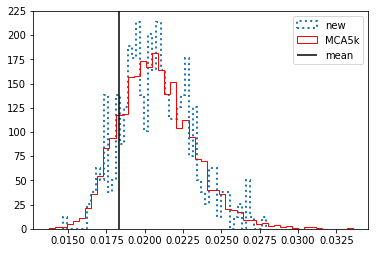

In [46]:
ax = plt.axes()
_ = plt.hist(res_mca, bins=50, density=True, axes=ax, histtype='step', linestyle=':', linewidth=2, label='new')
_ = plt.hist(a.scores(mca.method), bins=50, density=True, axes=ax, histtype='step', color=[1, 0, 0], 
             linestyle='-', linewidth=1, label='MCA5k')
yl = ax.get_ylim()
ax.vlines(lca.score, *yl, label='mean')
ax.set_ylim(yl)
ax.legend()

So that looks good too. So the monte carlo distribution just skews high for this process for "some reason"